# Network embedding via GConv-AE

In this notebook we aim to derive a node embedding for the regulatory network of U2OS cells that we derived in our preceeding analyses. To this end, we will train a graph-convolutional autoencoder of the same latent dimension size as our image embeddings namely 1024. 

The GAE will be trained on the task of link prediction to capture the overall network structure. Additionally we provide two other supervisory signals one coming from a feature reconstruction task and one from a classification task. The former aims to ensure that the learned embeddings also capture sufficient of the input feature characteristics and do not oversmooth those. The latter one is ensured to explicitely transfer information that are weakly captured in the graph structure and input features.

In fact, we will aim to infer latent gene embeddings by encoding the previously inferred gene-gene interactome of U2OS cells. The node features will be given by a combination of geneset membership information and single-cell gene expression data of U2OS cells in the control setting. Since we are interested in encoding the relationship of genes in different overexpression conditions, we will use the previously described classification objective to transfer cluster structure that was observed in derived differential expression gene signatures upon overexpression of the a given set of gene targets. This aims at laying out the inferred regulatory space such that it captures the OE conditions.

---

## 0. Environmental setup

We load all required libraries.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import sys
import os
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch import LongTensor, FloatTensor
from node2vec import Node2Vec
from torch_geometric.nn import GAE
from torch_geometric.utils import train_test_split_edges, from_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import InnerProductDecoder
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scanpy as sc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import spearmanr, pearsonr
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer

from scipy.spatial.distance import pdist, squareform
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from IPython.display import Image

sys.path.append("../../../")

from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *
from src.models.clf import LatentClassifier
from src.models.regressor import FeatureDecoder
from src.utils.basic.io import get_genesets_from_gmt_file
from src.models.ae import GCNEncoder

seed = 1234

plt.style.use("default")

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

We next load the previously inferred gene-gene interactome.

In [2]:
spearman_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/cmap_abssig_ccle_spearmanr_sol_cv.pkl"
)
print(spearman_interactome)

Graph named 'cmap_abssig_ccle_spearmanr_sol' with 357 nodes and 1138 edges


<IPython.core.display.Javascript object>

The network consists of 357 nodes and 1138 edges.

Next, we load the single-cell gene expression data which we will use as node features in order to encode functional relationships in the control setting which we expect to partially conserved even in the overexpression settings.

In [3]:
gex_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
gex_adata.var_names_make_unique()
gex_data = pd.DataFrame(
    gex_adata.X, columns=gex_adata.var_names, index=gex_adata.obs_names
)
gex_data.columns = [c.upper() for c in gex_data.columns]
gex_data = gex_data.loc[
    :, set(spearman_interactome.nodes()).intersection(gex_data.columns)
]

<IPython.core.display.Javascript object>

We also load the gene signatures of the CMAP data set and the previously identified clusters of those for a subset of the genes covered in the inferred gene-gene interactome. As described earlier those will be used in order to guide the inference such that the effect of the overexpression of individual genes is reflected in the determined node embeddings.

In [4]:
cmap_data = pd.read_csv("../../../data/gex/cmap/mean_l5_signatures.csv", index_col=0)
cmap_gene_set = set(cmap_data.columns)

<IPython.core.display.Javascript object>

In [5]:
cmap_clusters = pd.read_csv(
    "../../../data/other/mean_cmap_sig_clusters.csv", index_col=0
)

<IPython.core.display.Javascript object>

Finally, we read in a number of descriptive gene sets. Out of those especially the Hallmark gene set has been previously successfully used as a node feature to encode protein-protein interactomes and thus will be also used in our study.

In [6]:
spec_results = pd.read_csv(
    "../../../data/other/specificity_results/specificity_screen_results_cv.csv",
    index_col=0,
)
spec_results = spec_results.loc[spec_results["selected"] == True]
spec_orf_targets = set(spec_results.index)
hallmark_geneset_dict = get_genesets_from_gmt_file(
    "../../../data/other/genesets/h.all.v7.4.symbols.gmt"
)

l1000_genes = set(
    list(
        pd.read_csv(
            "../../../data/other/genesets/l1000.txt", index_col=0, header=None
        ).index
    )
)

mean_physical_clusters = pd.read_csv(
    "../../../data/other/mean_physical_clusters.csv", index_col=0
)

lut = dict(
    zip(
        list(np.unique(mean_physical_clusters.cluster)),
        [
            "tab:blue",
            "tab:red",
            "tab:green",
            "gold",
            "tab:orange",
            "tab:cyan",
            "purple",
            "tab:pink",
            "tab:olive",
            "tab:cyan",
            "tab:brown",
        ],
    )
)
mean_physical_clusters["color"] = mean_physical_clusters["cluster"].map(lut)


<IPython.core.display.Javascript object>

---
---

## 2. Preprocessing

We will now set the respective node and edge attributes computed based on the previously loaded information. Note, that the single-cell gene expression data is min-max-scaled.

### 2.1. Attribute setting

In [7]:
gex_data_z = pd.DataFrame(
    MinMaxScaler().fit_transform(gex_data.transpose()),
    index=gex_data.transpose().index,
    columns=gex_data.transpose().columns,
).transpose()

<IPython.core.display.Javascript object>

In [8]:
cmap_data_z = pd.DataFrame(
    MinMaxScaler().fit_transform(cmap_data.transpose()),
    index=cmap_data.transpose().index,
    columns=cmap_data.transpose().columns,
).transpose()

<IPython.core.display.Javascript object>

In [9]:
for node in spearman_interactome.nodes(data=True):
    node[-1]["sc_gex"] = np.array(gex_data_z.loc[:, node[0]])
    node[-1]["sc_gex"] = node[-1]["sc_gex"]
    # node[-1]["cmap_sig"] = np.array(cmap_data_z.loc[:, node[0]])
    if node[0] in mean_physical_clusters.index:
        node[-1]["label"] = mean_physical_clusters.loc[node[0], "cluster"]
        node[-1]["label_mask"] = True
    else:
        node[-1]["label"] = -1
        node[-1]["label_mask"] = False
    node[-1]["name"] = node[0]
    node[-1]["spec_target"] = node[0] in spec_orf_targets

    gene_memberships = []
    for geneset in hallmark_geneset_dict.values():
        if node[0] in geneset:
            gene_memberships.append(1.0)
        else:
            gene_memberships.append(0.0)

    node[-1]["hallmark"] = np.array(gene_memberships)
    node[-1]["sc_gex_hallmark"] = np.concatenate(
        [node[-1]["sc_gex"], node[-1]["hallmark"]]
    )

<IPython.core.display.Javascript object>

---

### 2.2 Data preparation

Next, we transform the graph into a data object complient with the used pytorch_geometric framework to learn the graph embeddings.

In [10]:
device = torch.device("cpu")

graph_data = from_networkx(spearman_interactome)
graph_data.id = torch.FloatTensor(np.identity(len(spearman_interactome)))
graph_data = T.ToDevice(
    device,
    attrs=[
        "id",
        "sc_gex",
        "cmap_sig",
        "label",
        "label_mask" "hallmark",
        "sc_gex_hallmark",
        "cmap_sig_hallmark",
        "cmap_sig_sc_gex_hallmark",
    ],
)(graph_data)

<IPython.core.display.Javascript object>

In [11]:
np.unique(cmap_clusters.cluster)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<IPython.core.display.Javascript object>

---
---

## 3. Node embeddings

Next, we aim at inferring the regulatory space in U2OS cells by encoding the previously inferred gene-gene interactome in the way described above.

### 3.1. Model setup

As a first step, we thus define the graph autoencoder model in addition to a feature decoder and a latent classification model which will jointly guide the inference.


In [12]:
input_dim = 1176
latent_dim = 1024

gae = GAE(GCNEncoder(in_channels=input_dim, out_channels=latent_dim, hidden_dim=1024))
feature_decoder = FeatureDecoder(
    latent_dim=latent_dim,
    hidden_dims=[1024],
    output_dim=input_dim,
    loss_fct=torch.nn.L1Loss(),
)
latent_classifier = LatentClassifier(
    latent_dim=latent_dim, hidden_dims=None, n_classes=11, loss_fct=None
)

<IPython.core.display.Javascript object>

---

##### Hallmark-GEX GAE (adjacency & feature reconstruction) with link splitting

We train the model on the adjacency and feature reconstruction task to monitor the model performance we split the existing links into 0.7 for training, 0.1 for validation and 0.2 for training. The training is early stopped if the performance of the link prediction task does no longer improve as measured by the BCELoss.

In [13]:
seeds = [1234, 2345, 3456, 4567]
seeds = [1234]

<IPython.core.display.Javascript object>

In [20]:
node_feature_key = "cmap_sig_hallmark"
edge_weight_key = None

print("Latent dim: {}".format(1024))
latents_dict, loss_hist_dict = get_gae_latents_for_seed(
    graph_data=graph_data,
    gae=gae,
    seeds=seeds,
    node_feature_key=node_feature_key,
    edge_weight_key=edge_weight_key,
    feature_decoder=None,
    latent_classifier=None,
    n_epochs=6000,
    lr=0.00001,
    split_type="link",
    alpha=1,
    beta=0,
    gamma=0,
    plot_loss=True,
    early_stopping=100,
    use_full_graph=False,
    neg_edge_ratio=1.0,
)

Latent dim: 1024


  0%|          | 0/6000 [00:00<?, ?it/s]


AttributeError: 'GlobalStorage' object has no attribute 'cmap_sig_hallmark'

<IPython.core.display.Javascript object>

---

### 3.3. Analyses of the inferred node embeddings

As discussed earlier, we will select the embeddings obtained from the previously described model as the final embeddings of the nodes in our network. We now will visualize and analyze the node embeddings with respect to their clustering to validate that e.g. genes which are known to function together co-cluster in the embedding space.

#### Visualization of the inferred latent space

In [15]:
latents = latents_dict[1234]

<IPython.core.display.Javascript object>

In [16]:
node_names = getattr(graph_data, "name")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [17]:
latents = pd.DataFrame(latents, index=node_names)

<IPython.core.display.Javascript object>

In [18]:
embs = TSNE(
    random_state=1234,
    perplexity=int(np.sqrt(len(latents))) + 1,
    init="pca",
    learning_rate="auto",
).fit_transform(latents)
embs = pd.DataFrame(embs, columns=["tsne_0", "tsne_1"], index=node_names)
embs["spec_target"] = st_memberships.cpu().numpy()

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

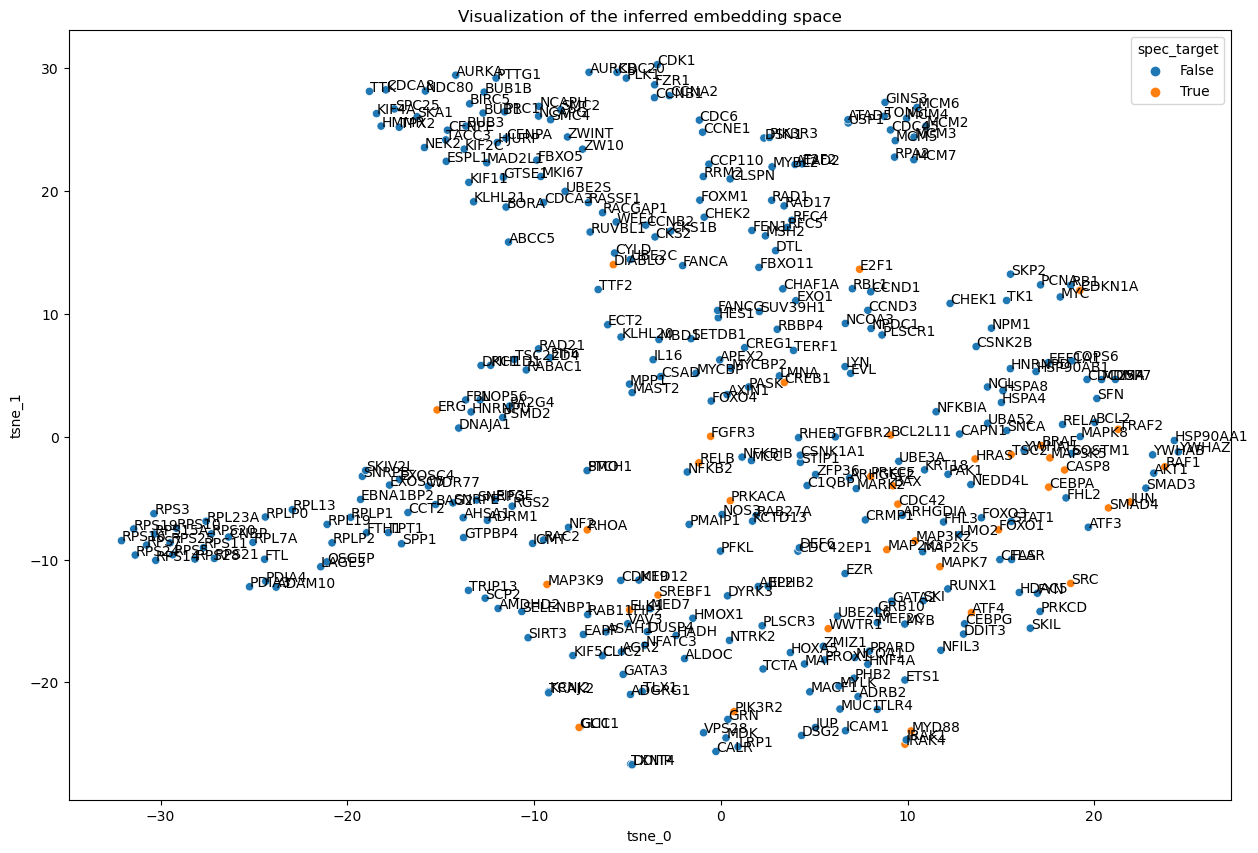

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plt.subplots(figsize=[15, 10])
ax = sns.scatterplot(
    data=embs, x="tsne_0", y="tsne_1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne_0"]),
    np.array(embs.loc[:, "tsne_1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)
ax.set_title("Visualization of the inferred embedding space")
plt.show()

#### Clustering of the embedding space

We will now perform a cluster analyses using hierarchical clustering based on the euclidean distances of the individual node embeddings and average linkage.

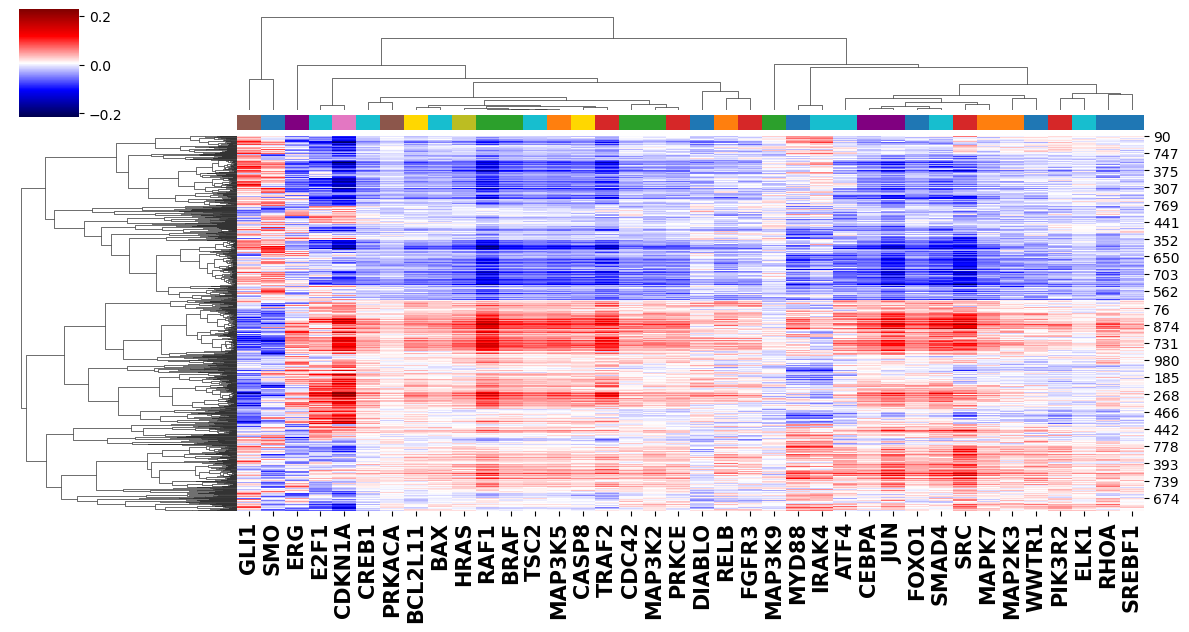

<IPython.core.display.Javascript object>

In [141]:
# latents = node_embs.copy()
ax = sns.clustermap(
    latents.loc[spec_orf_targets.intersection(latents.index)].transpose(),
    figsize=[12, 6],
    metric="cosine",
    method="complete",
    cmap="seismic",
    col_colors=np.array(
        mean_physical_clusters.loc[
            spec_orf_targets.intersection(latents.index), "color"
        ]
    ).ravel(),
)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

To better understand the clustering of the latent space, we will run a KMeans clustering analysis. To select the optimal number of clusters we look at a number of scores that have been proposed in the literature for a varying number of clusters. We set the range of clusters to 2-15 as in the previous study.

In [10]:
latents = pd.read_csv("../../../data/ppi/embedding/lm_old_interactome/node_embs_a1_b1_g1_phy.csv", index_col=0)

<IPython.core.display.Javascript object>

In [11]:
from sklearn.preprocessing import normalize

norm_latents = pd.DataFrame(
    normalize(latents), index=latents.index, columns=latents.columns
)

<IPython.core.display.Javascript object>

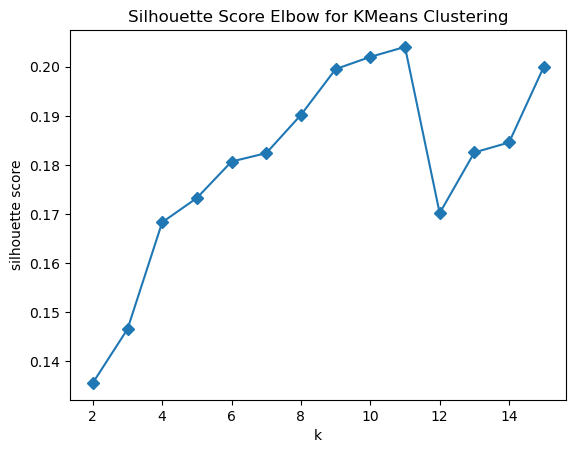

<IPython.core.display.Javascript object>

In [18]:
model = KMeans(random_state=seed)
#model = AgglomerativeClustering(affinity="cosine", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(norm_latents)
ax = visualizer.show()

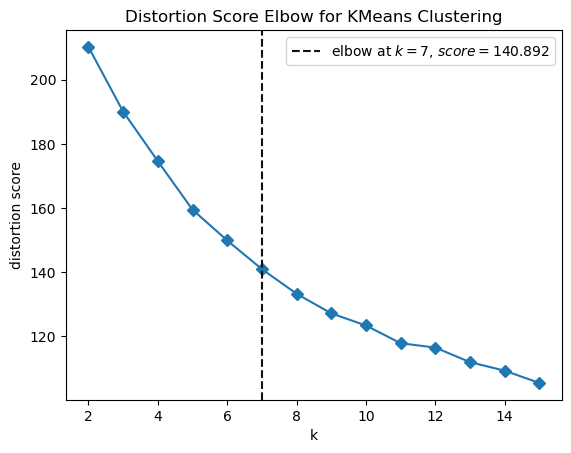

<IPython.core.display.Javascript object>

In [13]:
visualizer = KElbowVisualizer(
    model, k=15, metric="distortion", timings=False, locate_elbow=True
)

visualizer.fit(norm_latents)
ax = visualizer.show()

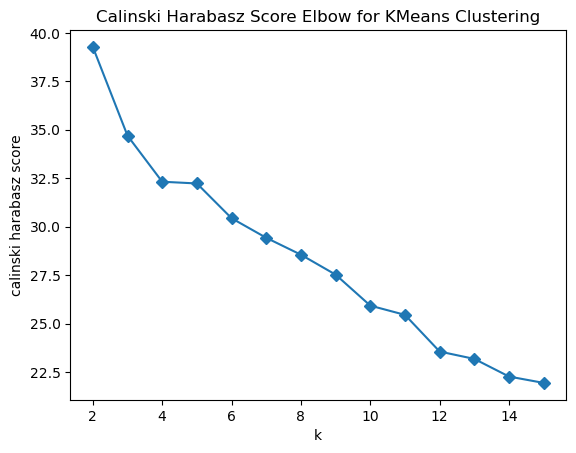

<IPython.core.display.Javascript object>

In [14]:
visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(norm_latents)
ax = visualizer.show()

When looking at computed cluster scores, we find that the maximum Calinski-Harabasz score is reached for a solution of k=5 clusters, which also matches the elbow of the distortion score. Thus, we decide to cluster the inferred latent space into 5 distinct clusters.

Next, we aim to characterize the meaning of these clusters using a gene ontology analysis to identify the four GO terms associated with the clusters that have the lowest FDR. Clusters with no significant GO terms will be marked accordingly.

In [21]:
print(list(latents.index))

['PTN', 'KLK6', 'AURKB', 'TRAF2', 'TNNC1', 'KRT80', 'SDC1', 'SPC24', 'MCM3', 'TUBB', 'FHL2', 'MAGED1', 'TNNT2', 'CDC20', 'COL5A1', 'NUF2', 'PLAT', 'TINAGL1', 'APPBP2', 'C1QL1', 'CNN1', 'GSK3B', 'IRF7', 'CEP192', 'BUB1', 'VIM', 'INHBA', 'SMAD4', 'HRAS', 'HSPG2', 'AURKA', 'CENPA', 'ATXN7', 'TRIB3', 'COL4A1', 'MYH9', 'PCOLCE', 'BMP4', 'CYBA', 'THBS1', 'ELK1', 'ARMCX2', 'CDC6', 'RUNX1', 'MAPK7', 'BUB1B', 'NEK2', 'NEFL', 'UCHL5', 'FGF1', 'SFN', 'FOXO1', 'NCAM1', 'YWHAQ', 'FBN2', 'GTSE1', 'ERG', 'CDCA3', 'UBE2C', 'TP73', 'SPC25', 'EEF1A2', 'MDK', 'CCND2', 'KRT15', 'PRKCE', 'BEX1', 'HJURP', 'DSP', 'TCF4', 'HK2', 'NDN', 'MSH2', 'CKS2', 'GABRB3', 'SMO', 'E2F1', 'THRA', 'PDGFRB', 'ATF4', 'S100A14', 'EPB41L3', 'PRSS23', 'PARP2', 'PRKCA', 'TUBB2B', 'MCM10', 'FN1', 'CDC42', 'NCF2', 'RHOA', 'MDC1', 'RPS6KB1', 'SDC3', 'VCAN', 'PLK1', 'MKI67', 'TPM2', 'HSPA1B', 'FOXM1', 'LBH', 'KIF23', 'NOTCH3', 'GNAQ', 'CENPE', 'KIF2C', 'MAP2K3', 'KRT8', 'TENM3', 'MAPK8', 'TNC', 'PRC1', 'MYC', 'LAMA1', 'PLCG1', 'RRM2

<IPython.core.display.Javascript object>

In [19]:
model = KMeans(n_clusters=5, random_state=seed)
# model = AgglomerativeClustering(n_clusters=4, affinity="cosine", linkage="complete")
cluster_labels = model.fit_predict(norm_latents)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(norm_latents.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, sorted(v)))
    print("")

Cluster 0: ['AKT1S1', 'ATXN7', 'AXL', 'BCR', 'BEX1', 'BRAF', 'CD40', 'CDC42', 'CDC42EP1', 'CDCA3', 'CDK14', 'CNN1', 'CYBA', 'DIABLO', 'DSP', 'EFEMP1', 'FGF1', 'FGFR2', 'FGFR3', 'FKBP4', 'HK2', 'HRAS', 'HSP90AB1', 'HSPA1B', 'HSPB1', 'KPNA2', 'KRT15', 'KRT18', 'KRT8', 'KRT80', 'KRT81', 'LGALS1', 'MAGEA1', 'MAGEA12', 'MAGED1', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MDFI', 'MYL2', 'NCAM1', 'NCF2', 'NEFL', 'PAK2', 'PDGFRB', 'PIK3R2', 'PLCB2', 'PLCG1', 'PRKCE', 'RAF1', 'RHOA', 'S100A2', 'SFN', 'SRC', 'THRA', 'TINAGL1', 'TNNT1', 'TPM1', 'TRAF2', 'TUBA1A', 'TUBB', 'TUBB6', 'UCHL5', 'VIM', 'YWHAQ']

Cluster 1: ['ALOX5', 'AMPH', 'AQP1', 'ATF4', 'BAX', 'BCL2L11', 'C1QL1', 'CASP8', 'CEBPA', 'CLU', 'CREB1', 'CRYAB', 'EEF1A2', 'EPB41L3', 'ERG', 'FHL2', 'FOS', 'FOXO1', 'GABRB3', 'GIT1', 'GLI1', 'GLI2', 'GNAQ', 'GSK3B', 'IRAK4', 'IRF7', 'JUN', 'LBH', 'LDOC1', 'LOXL4', 'LZTS2', 'MAGEA11', 'MAGEA6', 'MAPK7', 'MAPK8', 'MBP', 'MDC1', 'MYD88', 'NCOR2', 'NOTCH3', 'PARP2', 'PCLO', 'PRAME', 'PRKACA', 'PRKCA

<IPython.core.display.Javascript object>

The plot below shows the results of the GO analysis of the clustering solution. Note that we limit the visualization to the top-4 GO terms associated with a biological process that have the lowest FDR.

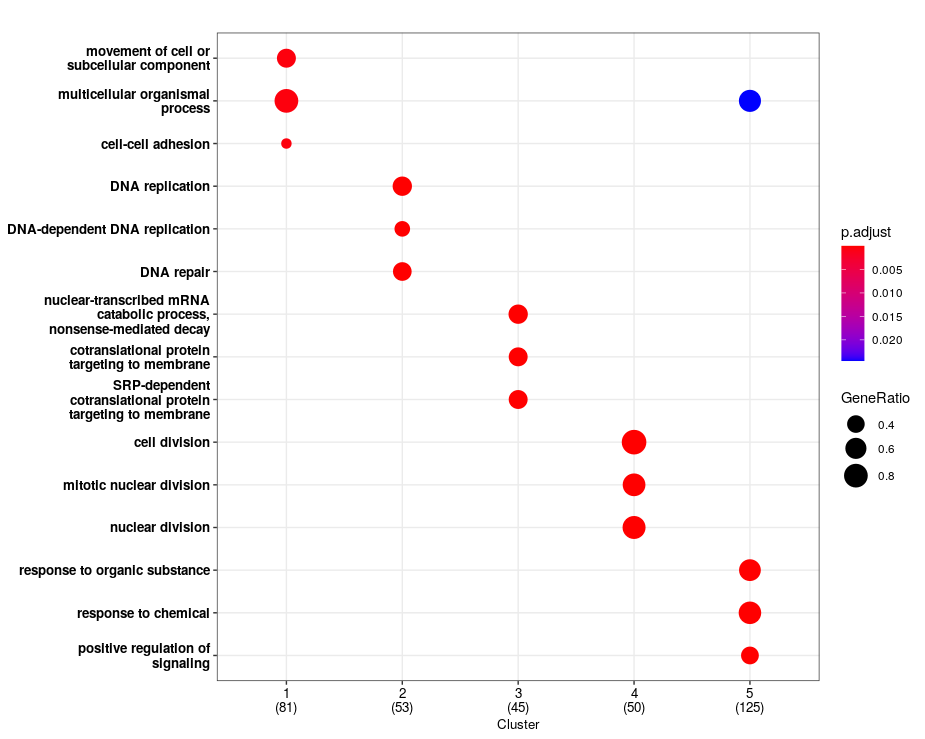

<IPython.core.display.Javascript object>

In [66]:
Image(
    filename="../../../data/figures/reg_space_cmap_prize_ccle_cost_5means_cluster_gae.png"
)

In [22]:
cluster_label_dict = {
    0: "Internal signal\ntransduction",
    1: "External signal\ntransduction",
    2: "Cell division",
    3: "DNA damage repair",
    4: "ECM interactions",
}

<IPython.core.display.Javascript object>

In [106]:
node_names = getattr(graph_data, "name")
st_memberships = getattr(graph_data, "spec_target")

cosine_latent_dist = pd.DataFrame(
    squareform(pdist(latents, metric="cosine")),
    index=latents.index,
    columns=latents.index,
)

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


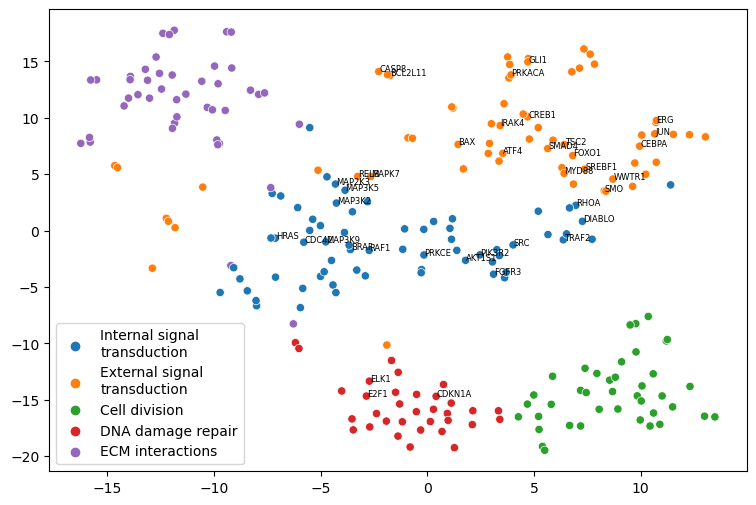

<IPython.core.display.Javascript object>

In [33]:
plt.style.use("default")
fig, ax = plt.subplots(figsize=[9, 6])
ax = plot_tsne_embs(
    norm_latents,
    ax,
    perplexity=30,
    random_state=1234,
    size=6,
    hue=list(pd.Series(cluster_labels).map(cluster_label_dict)),
    hue_order=list(cluster_label_dict.values()),
    palette=None,
    label_points=spec_orf_targets,
)
ax.legend(loc="lower left")

ax.set_xlabel("")
ax.set_ylabel("")
# ax.set_xlim([-30, 40])

plt.show()

---

### 3.4. Data export

We will now save the inferred node embeddings for later analyses.

In [84]:
latents.to_csv("../../../data/ppi/embedding/node_embs_a1_b0_g0_cmap_clusters.csv")

<IPython.core.display.Javascript object>

---

## 4. Translational analyses

We will now look at the co-clustering of those embeddings with the ones we obtain for the imaging space.

### 4.1. Read in data

First, we read in the previously computed network embedding serving as a proxy for the regulatory space in U2OS cells as well as the respective image embeddings which we use to model the structural space of those cells. Since, we have many images corresponding to a single over-expression condition we will use their mean embeddings as a description of the structural profile in U2OS cells associated with the respective single-gene OE condition.

In [85]:
node_embs = pd.read_csv(
    "../../../data/ppi/embedding/node_embs_a1_b1_g0_cmap_clusters.csv",
    index_col=0,
)

<IPython.core.display.Javascript object>

In [108]:
label_dict = {
    "AKT1S1": 0,
    "ATF4": 1,
    "BAX": 2,
    "BCL2L11": 3,
    "BRAF": 4,
    "CASP8": 5,
    "CDC42": 6,
    "CDKN1A": 7,
    "CEBPA": 8,
    "CREB1": 9,
    "CXXC4": 10,
    "DIABLO": 11,
    "E2F1": 12,
    "ELK1": 13,
    "EMPTY": 14,
    "ERG": 15,
    "FGFR3": 16,
    "FOXO1": 17,
    "GLI1": 18,
    "HRAS": 19,
    "IRAK4": 20,
    "JUN": 21,
    "MAP2K3": 22,
    "MAP3K2": 23,
    "MAP3K5": 24,
    "MAP3K9": 25,
    "MAPK7": 26,
    "MOS": 27,
    "MYD88": 28,
    "PIK3R2": 29,
    "PRKACA": 30,
    "PRKCE": 31,
    "RAF1": 32,
    "RELB": 33,
    "RHOA": 34,
    "SMAD4": 35,
    "SMO": 36,
    "SRC": 37,
    "SREBF1": 38,
    "TRAF2": 39,
    "TSC2": 40,
    "WWTR1": 41,
}
label_dict = {v: k for k, v in label_dict.items()}
img_embs = img_embs = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specificity_target_emb_cv_strat/final_1024/fold_0/test_latents.h5"
)
img_embs.iloc[:, -1] = img_embs.iloc[:, -1].map(label_dict)
img_embs = img_embs.groupby(by="labels").mean()

<IPython.core.display.Javascript object>

### 4.2. Translation analysis

Next, we will assess the co-clustering of our inferred estimates of the structural and the regulatory space using a similar approach as described earlier to assess the structural similarity of the different network embeddings.

In [120]:
latents = node_embs

<IPython.core.display.Javascript object>

In [144]:
shared_nodes = set(img_embs.index).intersection(node_embs.index)

<IPython.core.display.Javascript object>

In [145]:
from src.utils.notebooks.images.embedding import *

reg_perm_test_results = compute_cc_scores_perm_test(
    img_embs.loc[shared_nodes],
    latents.loc[shared_nodes],
    linkages=["complete", "complete"],
    affinities=["euclidean", "cosine"],
    score="mi",
    b=50,
    n_max_clusters=len(shared_nodes),
)

100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


<IPython.core.display.Javascript object>

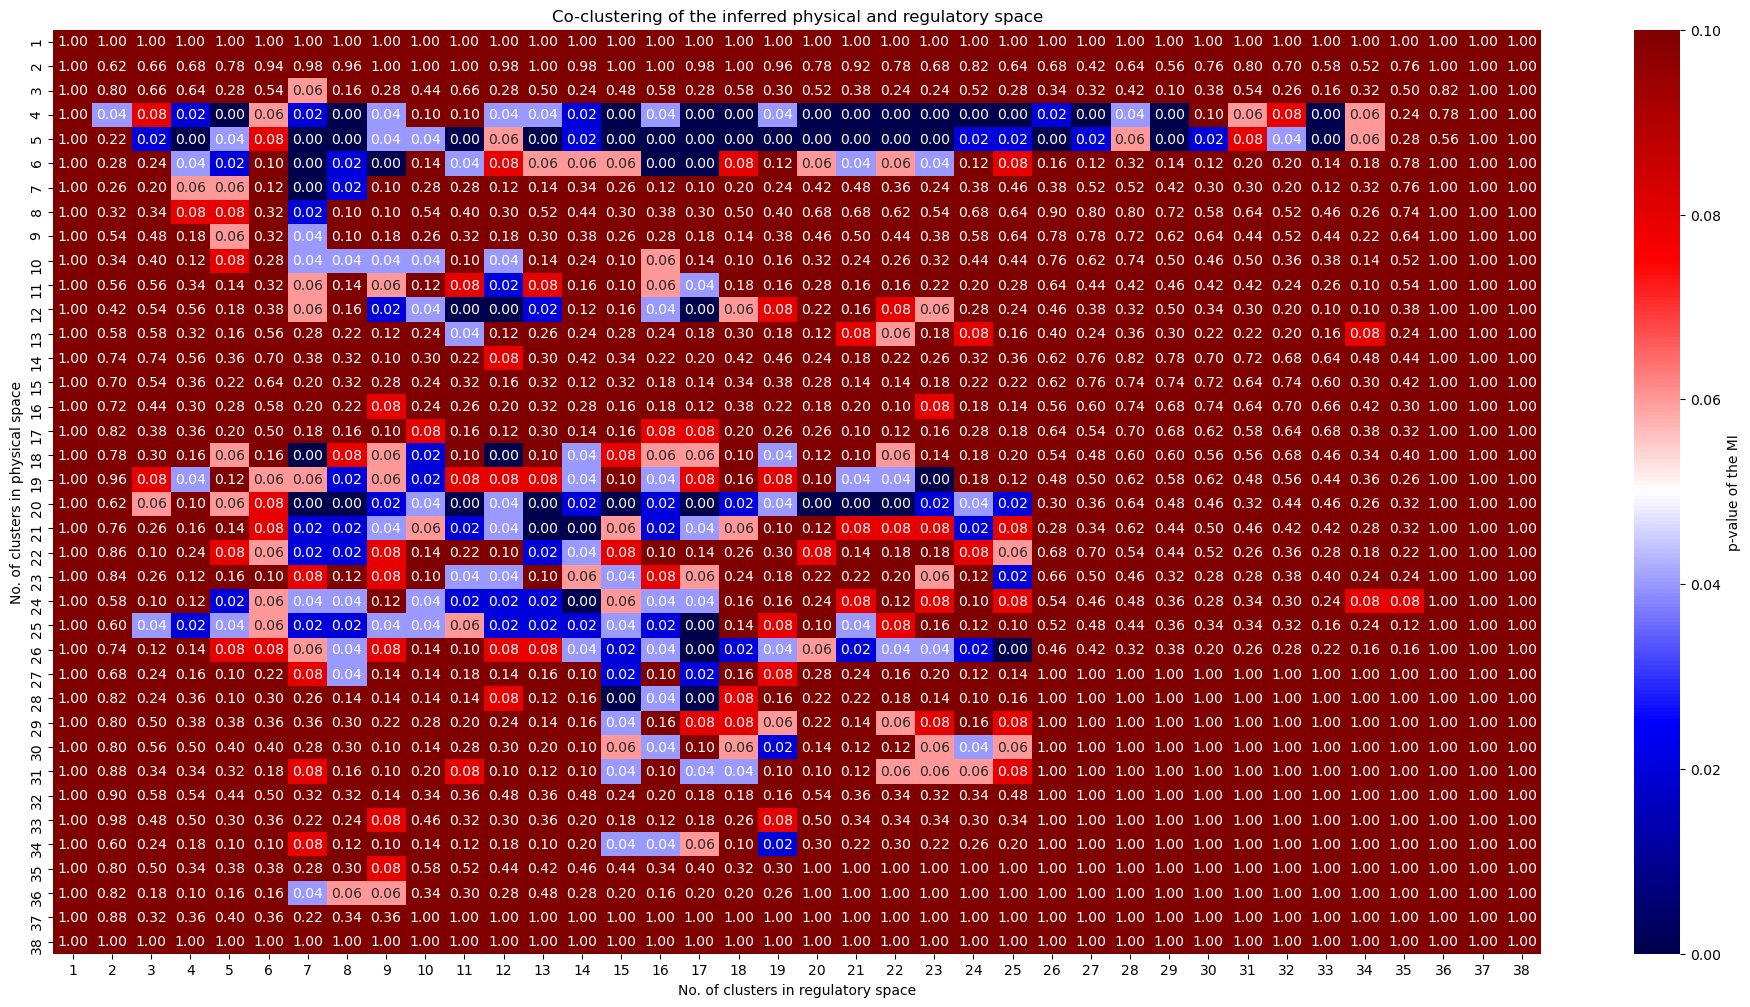

<IPython.core.display.Javascript object>

In [146]:
plot_cc_score(
    np.clip(reg_perm_test_results["pval"], 0, 1),
    "Co-clustering of the inferred physical and regulatory space",
    "p-value of the MI",
    figsize=[24, 12],
    fmt=".2f",
    cmap="seismic",
    vmin=0,
    vmax=0.1,
    space_names=["regulatory space", "physical space"],
)